## I. CLUSTER DYNAMICS

### Numerical Implementation
The numerical implementation of the TF model follows the approach of Kelton, Greer, and Thompson[^1] as used in previous works. The cluster size changes via single molecule attachment and detachment, as described by the master equations.

### Master Equations
The rate of change of the number density of *i*-mers is given by:

$$
\frac{dN_i}{dt} = D_{i+1}N_{i+1} + A_{i-1}N_{i-1} - (D_i + A_i)N_i
$$

Where:
- $ N_i $ is the number density of *i*-mers,
- $ i \geq u $, and *u* is the minimum cluster size treated numerically,
- $ A_i $ and $ D_i  4are the rates of single molecule attachment and detachment, respectively.

### Steady State Balance
At steady state ($ \theta = 0 $), the balance is given by:

$$
0 = A_{i-1}N_{eq,i-1} - D_iN_{eq,i+1}
$$

### Equilibrium Number Densities
The equilibrium number densities follow the Boltzmann distribution:

$$
N_{eq,i} = N_1 \exp\left(-\frac{W_i}{kT}\right)
$$

Where:
- $ W_i $ is the free energy of formation of the *i*-mer,
- $ k $ is the Boltzmann's constant,
- $ T $ is the temperature.

### Formation Rate of Clusters
The formation rate of clusters is concerned with the net formation rate of clusters of given size and the number density of such clusters. It is expressed as:

$$
J_i = A_iN_i - D_{i+1}N_{i+1}
$$

### Observable Cluster Size
The number of molecules in the cluster of "observable" size is:

$$
N_{>i_o} = \sum_{i=i_o+1}^{\infty} N_i
$$

### Boundary Conditions
The initial and boundary conditions are set as follows:
- At $ t = 0 $, the cluster population is $ N_i = N_{eq,i} $ for $ i < u $,
- $ N_i = 0 $ for $ i \geq u $ if not stated otherwise.

This corresponds to quenching from high temperatures where the molecules are dominantly in the monomer state; i.e., $ N_i = N_1 \exp\left(-\frac{W_i}{kT}\right) $, where $ W_i = 0 $ as monomers of the parent phase are not distinguishable.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import Nucleation_Dynamics as nd
from extensisq import BS5, SSV2stab, Pr9, CK5, CFMR7osc, Pr7
import Nucleation_Dynamics as nd
from diffeqpy import de, ode

import scienceplots
plt.style.use(['science','ieee'])

  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


For crystal nucleation in melt or glass, the rate of formation, \( A_i \), is expressed as:

$$
A_i = bDi^{2/3}\lambda^{-2} \exp\left(-\frac{W_{i+1} - W_i}{2kT}\right)
$$

where:
- $ b = 24 $ is a geometrical factor,
- $D $ is the diffusion coefficient,
- $\lambda $ is the jump distance in the parent phase.

### Initial and Boundary Conditions
The initial and boundary conditions applied are as follows:
- At $ t = 0 $, the cluster population is $ N_i = N_{eq,i} $ for $ i < u $,
- $ N_i = 0 $ for $ i \geq u $.

This corresponds to quenching from high temperatures where the molecules are dominantly in the monomer state; i.e., $ N_1 = N_L \exp\left(-\frac{W_1}{kT}\right) $, where $ W_1 = 0 $ as monomers of the parent and new phases cannot be distinguished.

The number density of monomers is kept constant at $ N_1(t) = N_{eq,1} $. A "no-depletion" boundary condition is applied for the monomers (lower boundary condition); i.e., their number density is constant. The number of molecules in the system depends on the boundary conditions, with a different upper boundary condition applied to enforce the conservation of supercritical clusters by closing the system at $ i_{max} $ and setting the rate coefficients $ A_{i_{max}} $ and $ D_{i_{max} + 1} $ equal to zero. 


For simplicity, spherical clusters with a sharp dividing surface, having the same composition as the parent phase, are assumed. Following Gibbs, the reversible work of formation of a cluster of size \( n \), constructed from \( n \) monomers, or molecules, is:

$$
\Delta G_n = n\Delta G' + (36\pi)^{\frac{1}{3}}v^{\frac{2}{3}}n^{\frac{2}{3}}\sigma ,
$$

where $ \Delta G' $ is the Gibbs free energy per molecule of the new phase less that of the initial phase, $ v $ is the molecular volume and $ \sigma $ is the interfacial energy per unit area. The surface energy penalty is dominant for small clusters, leading to a maximum in $ \Delta G_n $ at the critical size, $ n* $,

$$
n* = \frac{32\pi \sigma^3}{3v|\Delta G_v|^3} ,
$$

where $ \Delta G_v $ is the free energy difference per unit volume, $ \Delta G'/v $. Since clusters smaller than $ n* $ will on average shrink, while those larger than $ n* $ will on average grow, the nucleation rate is in a crude sense the production of postcritical clusters. Clusters are assumed to evolve in size by a series of bimolecular reactions.


In [2]:
# Ejemplo de uso de la clase

path = "data/lithium_disillicate.json"

cluster_physics = nd.ClusterPhysics(path)

print(f"Critical radius: {cluster_physics.critical_radius}")
print(f"Critical Gibbs free energy: {cluster_physics.critical_energy_barrier}")
print(f"Critical number of atoms: {cluster_physics.critical_number_of_molecules}")

Critical radius: 8.184545454545456e-10 meter
Critical Gibbs free energy: 4.2089037887339014e-19 joule
Critical number of atoms: 23.04237422754489 dimensionless


# Comparison free eneregy Gibbs (CNT model)

/home/alexandre_sureda/miniconda3/envs/neutronics/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


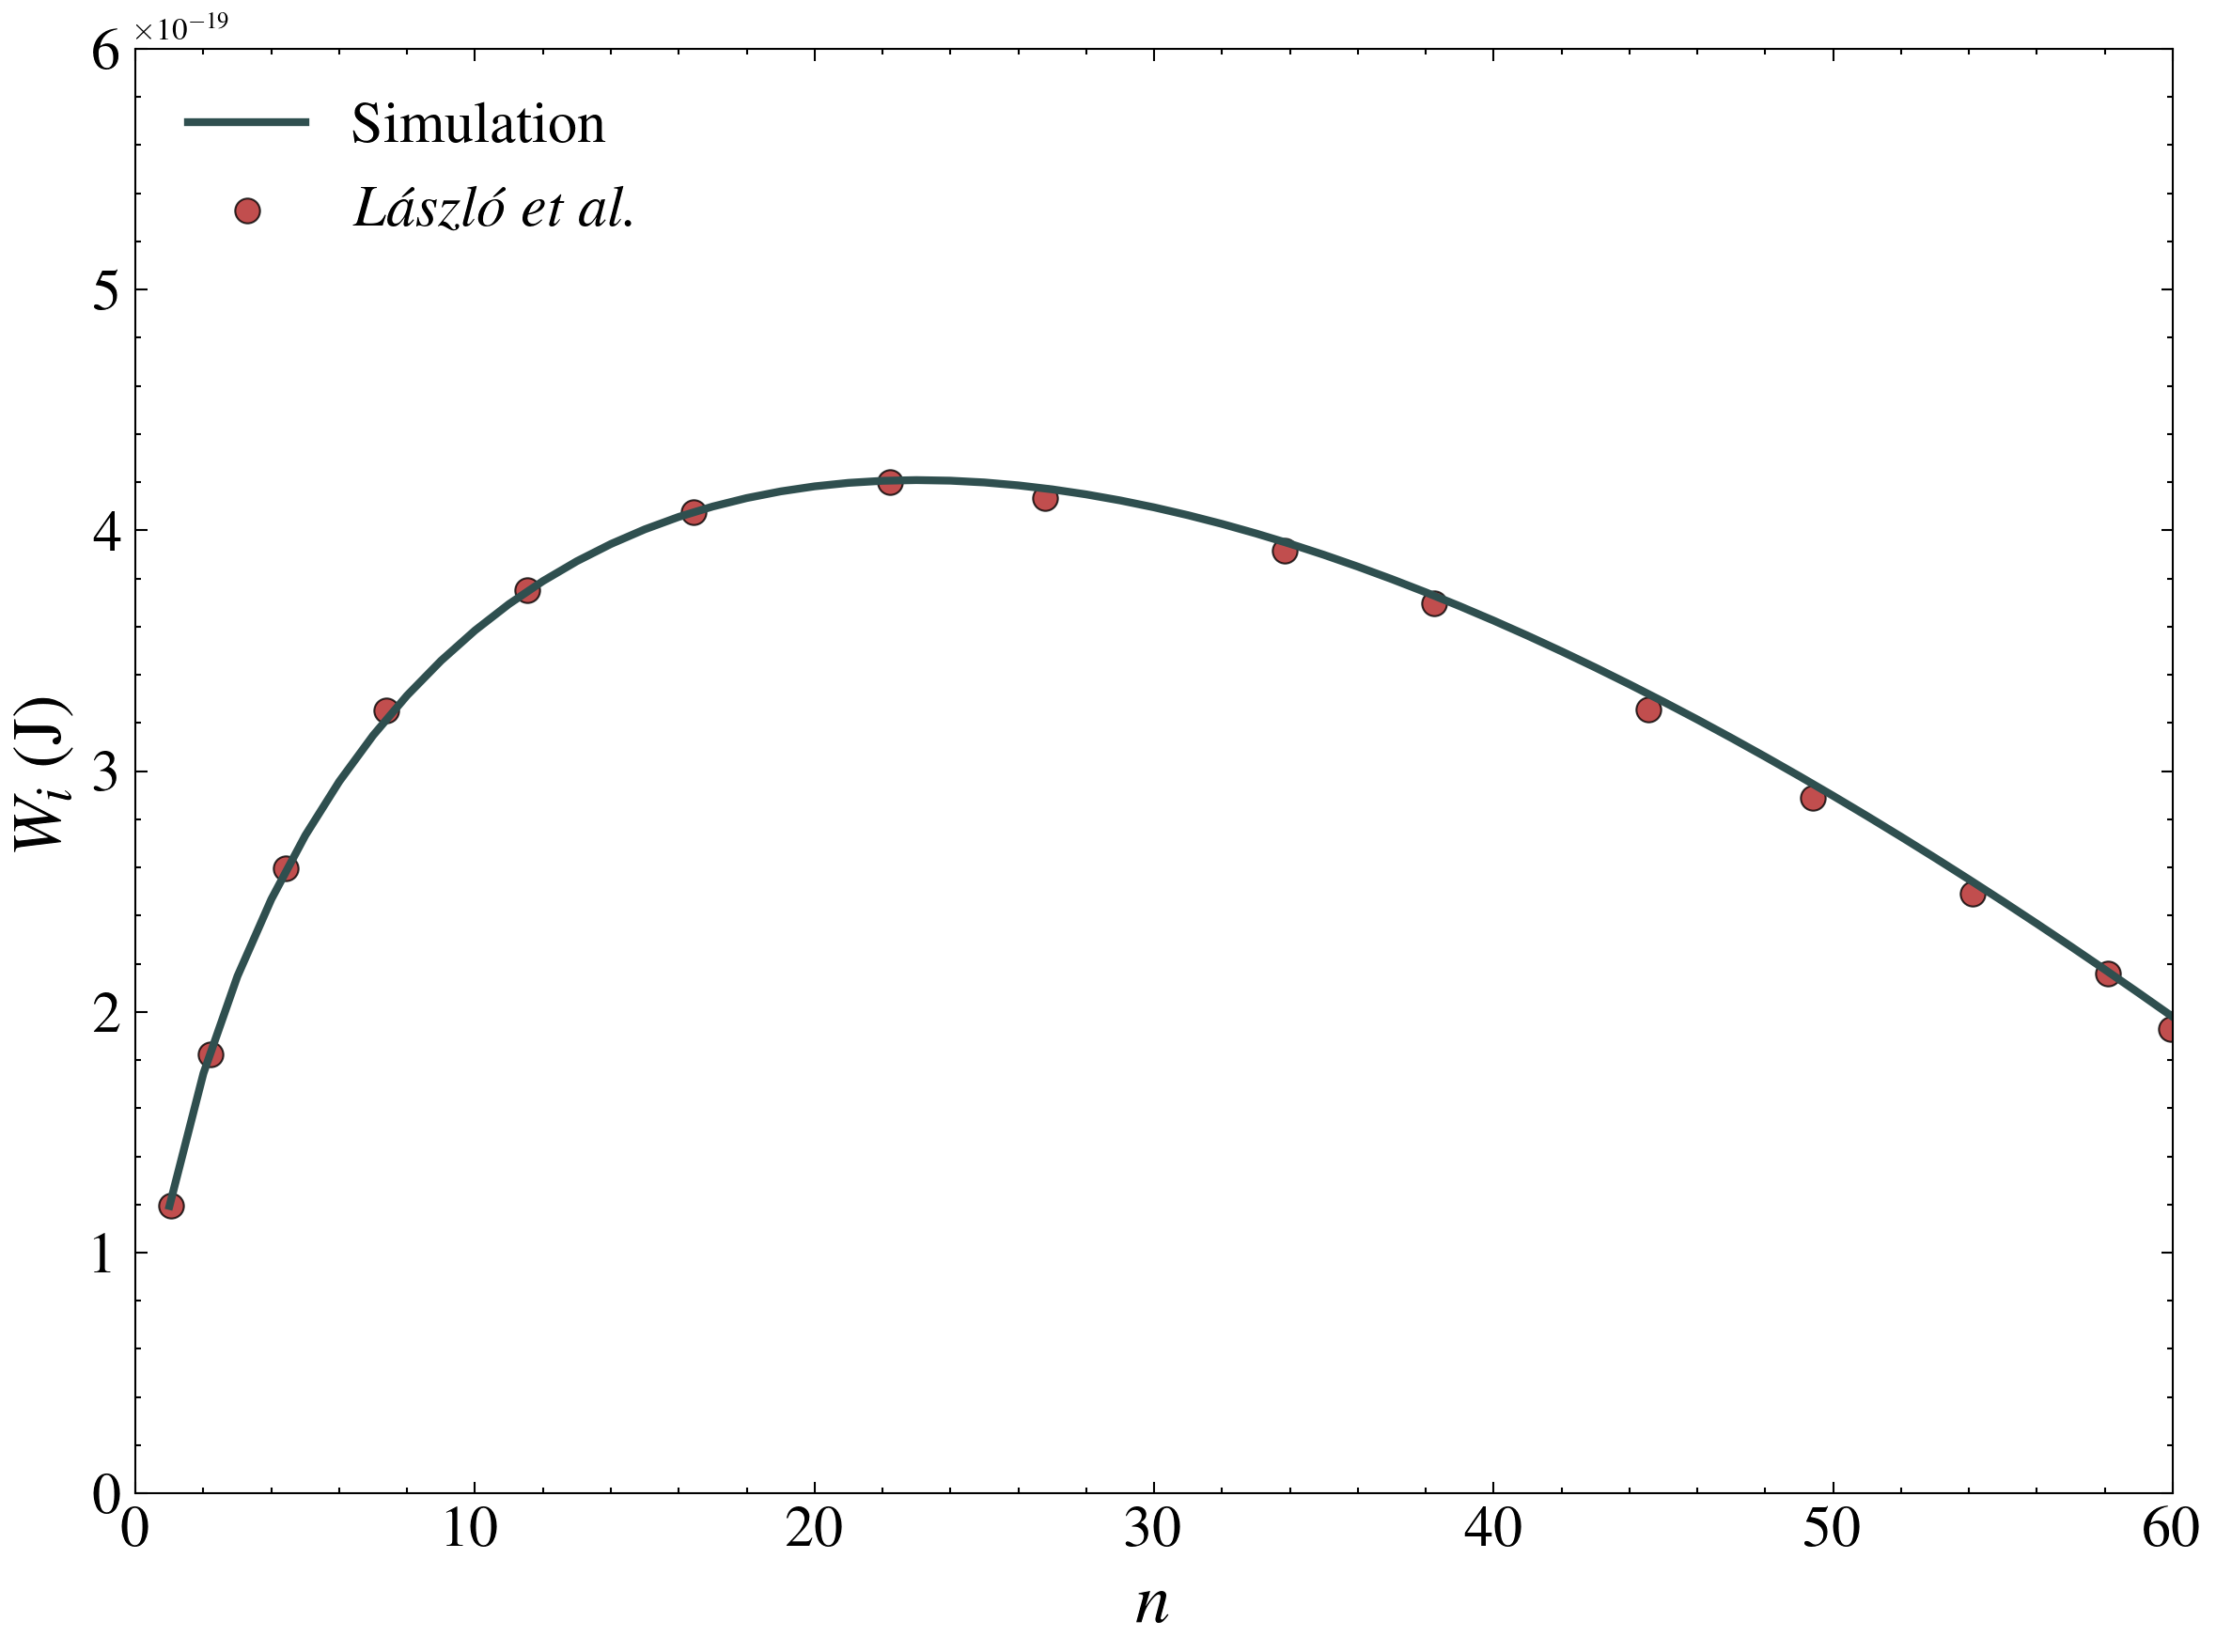

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Mejoras en la tipografía para revistas de física
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

# Carga de datos
df = pd.read_csv('data/lithium_disillicate_free_energy_40n_laszlo.csv')

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Preparación de datos
n = np.linspace(1, 60, 60)
# Asumiendo que 'cluster_physics.total_free_energy(n)' es una función definida previamente
ax.plot(n, cluster_physics.total_free_energy(n), label='Simulation', color='darkslategray', linewidth=2, linestyle='-')

# Dibujo de puntos con mejor color y mayor grosor de línea
ax.scatter(df["X"], df["Y"]*1e-19, label=r'\textit{László et al.}', s=40, color='firebrick', edgecolor='black', linewidth=0.5, alpha=0.8)

# Etiquetas y título con LaTeX para un aspecto profesional
ax.set_xlabel(r'$n$', fontsize=18)
ax.set_ylabel(r'$W_i$ (J)', fontsize=18)

# Ticks mejorados
ax.tick_params(axis='both', which='major', labelsize=15)

# Leyenda con tamaño de fuente aumentado y sin marco para un look limpio
ax.legend(loc='upper left', fontsize=15, frameon=False)

# Límites ajustados para enfocar en los datos relevantes
ax.set_xlim(0, 60)
ax.set_ylim(0, 6*1e-19)

# Ajuste de los márgenes y guardado con alta resolución
plt.tight_layout()

# Mostrar gráfico
plt.show()


In [71]:
MAX_NUMBER_MOLECULES = int(100)
number_clusters_start = 2
steps = int(2e5)
dt = 1e-8/cluster_physics.unbiased_jump_rate.magnitude
dt = dt*1e6
t_span = (0.0, dt*int(steps))

t_eval = np.linspace(*t_span, int(1e5))
sim = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method='BDF', t_eval=t_eval, rtol=1e-8, atol=1e-8)

sim2 = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES, boundary_type="open")
sim2.simulate(method='BDF', t_eval=t_eval, rtol=1e-8, atol=1e-8)


{'execution_time': 1.2208178043365479, 'success': True, 'nfev': 2349}
{'execution_time': 1.061452865600586, 'success': True, 'nfev': 1997}


## Comparison cluster disitribution 

In [86]:
max_number_simulation = [40, 100]
number_clusters_start = 2
steps = int(2e5)
dt = 1e-8/cluster_physics.unbiased_jump_rate.magnitude
dt = dt*1e6
t_span = (0.0, dt*int(steps))

t_eval = np.linspace(*t_span, int(1e5))

simulations_closed = []
for max_number in max_number_simulation:
    sim = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, max_number)
    sim.simulate(method='BDF', t_eval=t_eval, rtol=1e-8, atol=1e-8)
    simulations_closed.append(sim)

simulations_open = []
for max_number in max_number_simulation:
    sim = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, max_number, boundary_type="open")
    sim.simulate(method='BDF', t_eval=t_eval, rtol=1e-8, atol=1e-8)
    simulations_open.append(sim)


{'execution_time': 0.6123912334442139, 'success': True, 'nfev': 1935}
{'execution_time': 1.226287603378296, 'success': True, 'nfev': 2349}
{'execution_time': 0.5547165870666504, 'success': True, 'nfev': 1761}
{'execution_time': 1.0160789489746094, 'success': True, 'nfev': 1997}


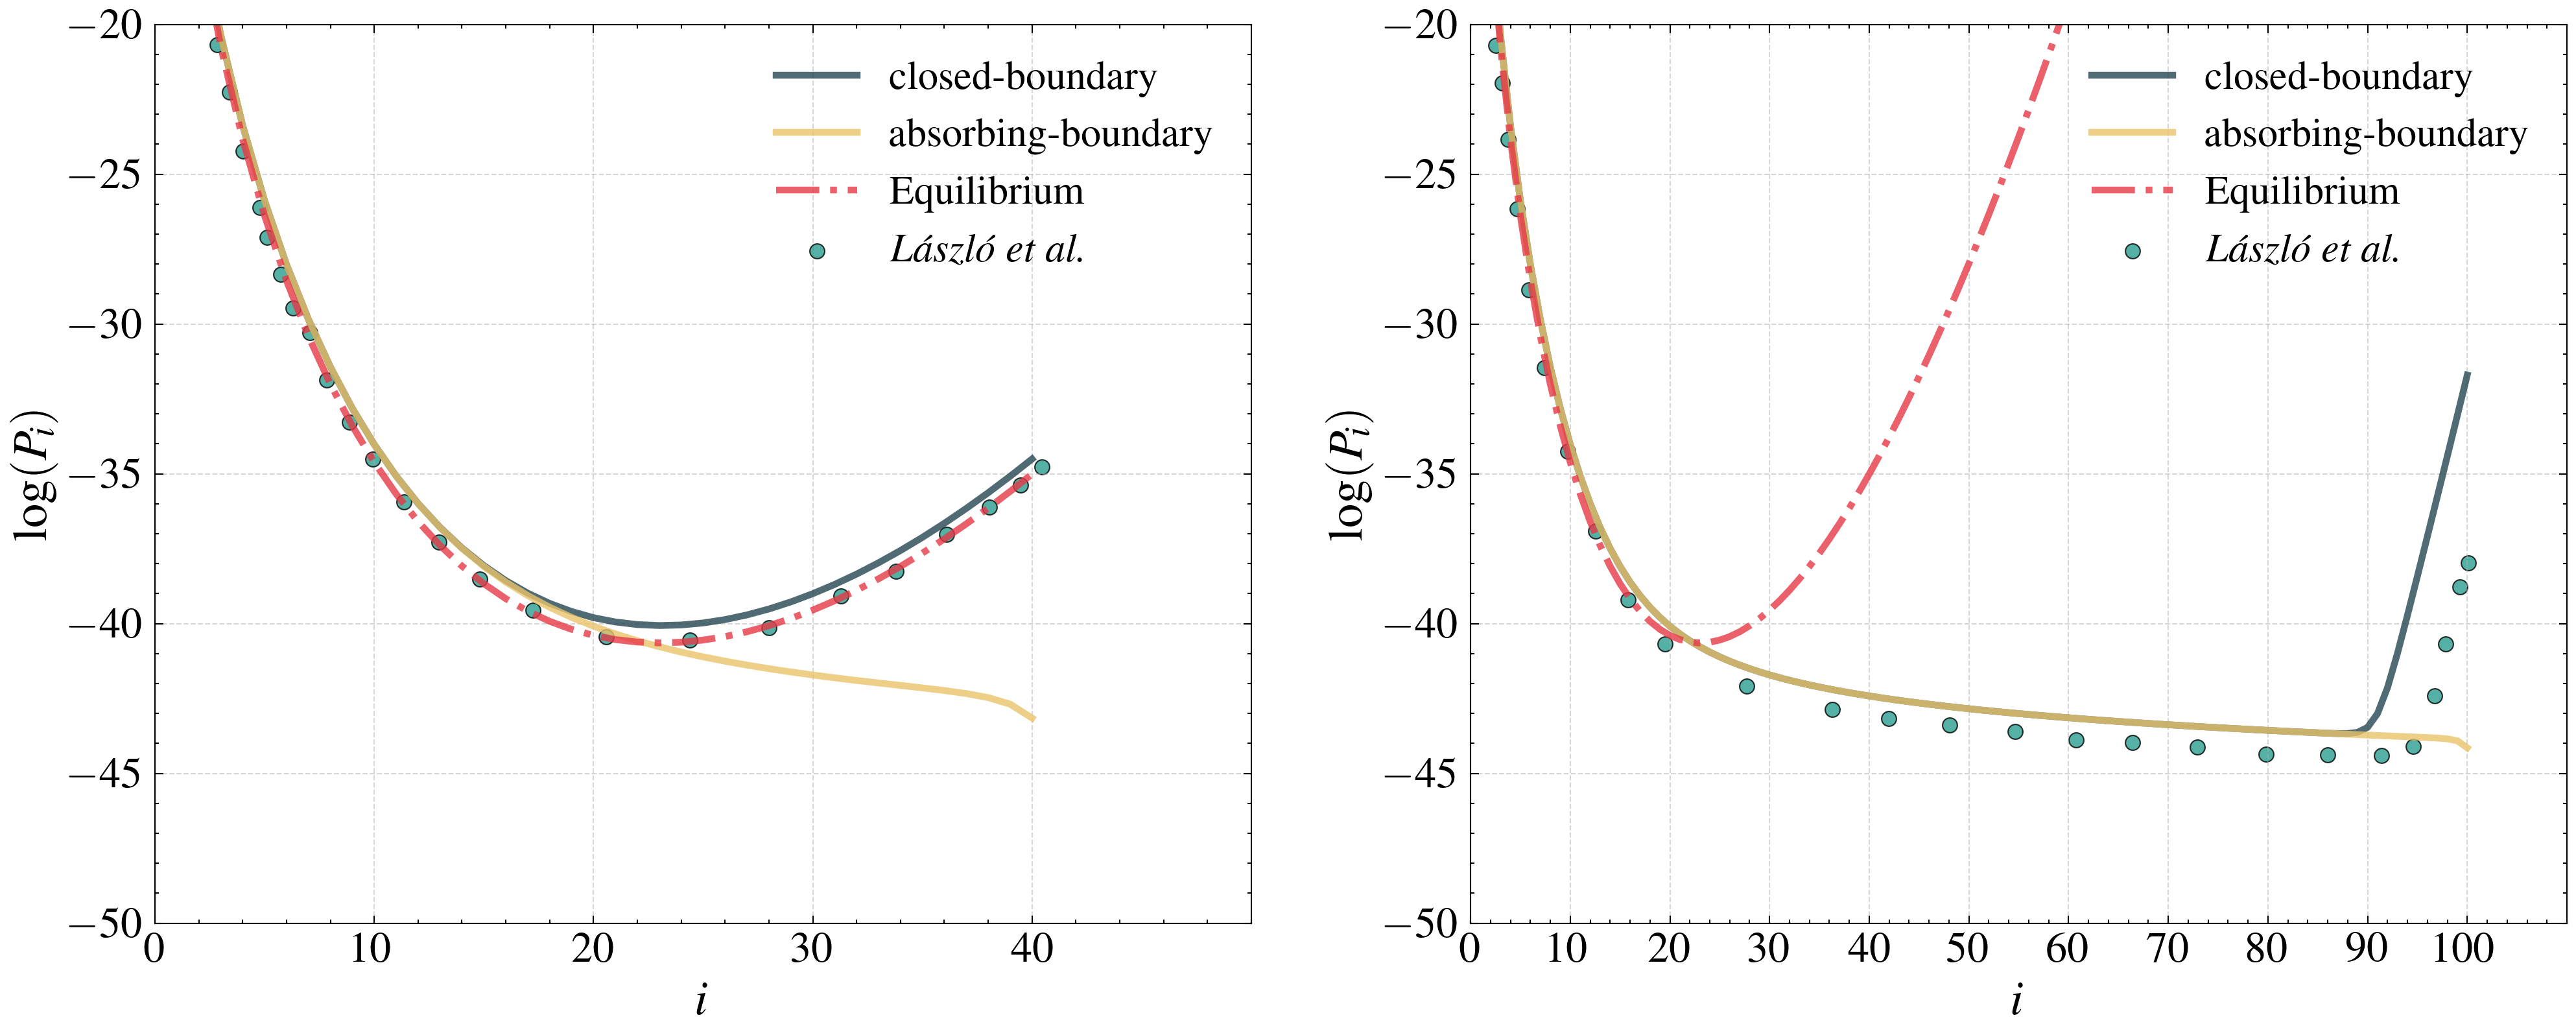

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Asegúrate de importar pandas

# Carga de datos
df = pd.read_csv('data/lithium_disillicate_40n_laszlo.csv')
df2 = pd.read_csv('data/lithium_disillicate_100n_laszlo.csv')
df_list = [df, df2]

# Definir paletas de colores y estilos de línea más elegantes
colors = {
    'closed-boundary': '#264653',  # Azul petróleo, oscuro y saturado
    'absorbing-boundary': '#e9c46a',  # Ámbar dorado, saturado pero suave
    'Laszlo': '#2a9d8f',  # Verde selva, saturado y elegante
    'Equilibrium':  '#e63946'  # Naranja terracota, saturado y cálido
}

line_styles = {
    'closed-boundary': '-',  # Línea sólida
    'absorbing-boundary': '-',  # Línea sólida
    'Equilibrium': 'dashdot'  # Línea punteada
}

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=300)
for n in range(len(simulations_closed)):
    # Definir el rango de números de moléculas
    number_molecules_array = np.arange(1, max_number_simulation[n] + 1)
    ax = axs[n]
    ax.plot(number_molecules_array, np.log(simulations_closed[n].cluster_array[:, -1] / cluster_physics.AVOGADRO.magnitude),
                label="closed-boundary", color=colors['closed-boundary'], linestyle = line_styles['closed-boundary'], linewidth=2.5, alpha=0.8)

    ax.plot(number_molecules_array, np.log(simulations_open[n].cluster_array[:, -1] / cluster_physics.AVOGADRO.magnitude),
                label="absorbing-boundary",  color=colors['absorbing-boundary'], linestyle = line_styles['absorbing-boundary'], linewidth=2.5, alpha=0.8)

    ax.plot(number_molecules_array, np.log(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
            label="Equilibrium", color=colors['Equilibrium'], alpha=0.8, linestyle = line_styles['Equilibrium'], linewidth=2.5)

    ax.scatter(df_list[n]['X'], df_list[n]['Y'],
                label=r'\textit{László et al.}', color=colors['Laszlo'], s=30, edgecolor='black', linewidth=0.5, alpha=0.8)
    
    ax.set_xlim(1, max_number_simulation[n]+10)
    ax.set_ylim(-50, -20)
    ax.set_xticks(np.arange(0, max_number_simulation[n]+10, 10))
    ax.set_yticks(np.arange(-50, -19, 5)) 
    # Ticks mejorados
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(r'$i$', fontsize=18)
    ax.set_ylabel(r'$\log(P_i)$', fontsize=18)
    ax.legend(fontsize=15, loc='upper right')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()


## KINETIC RATES

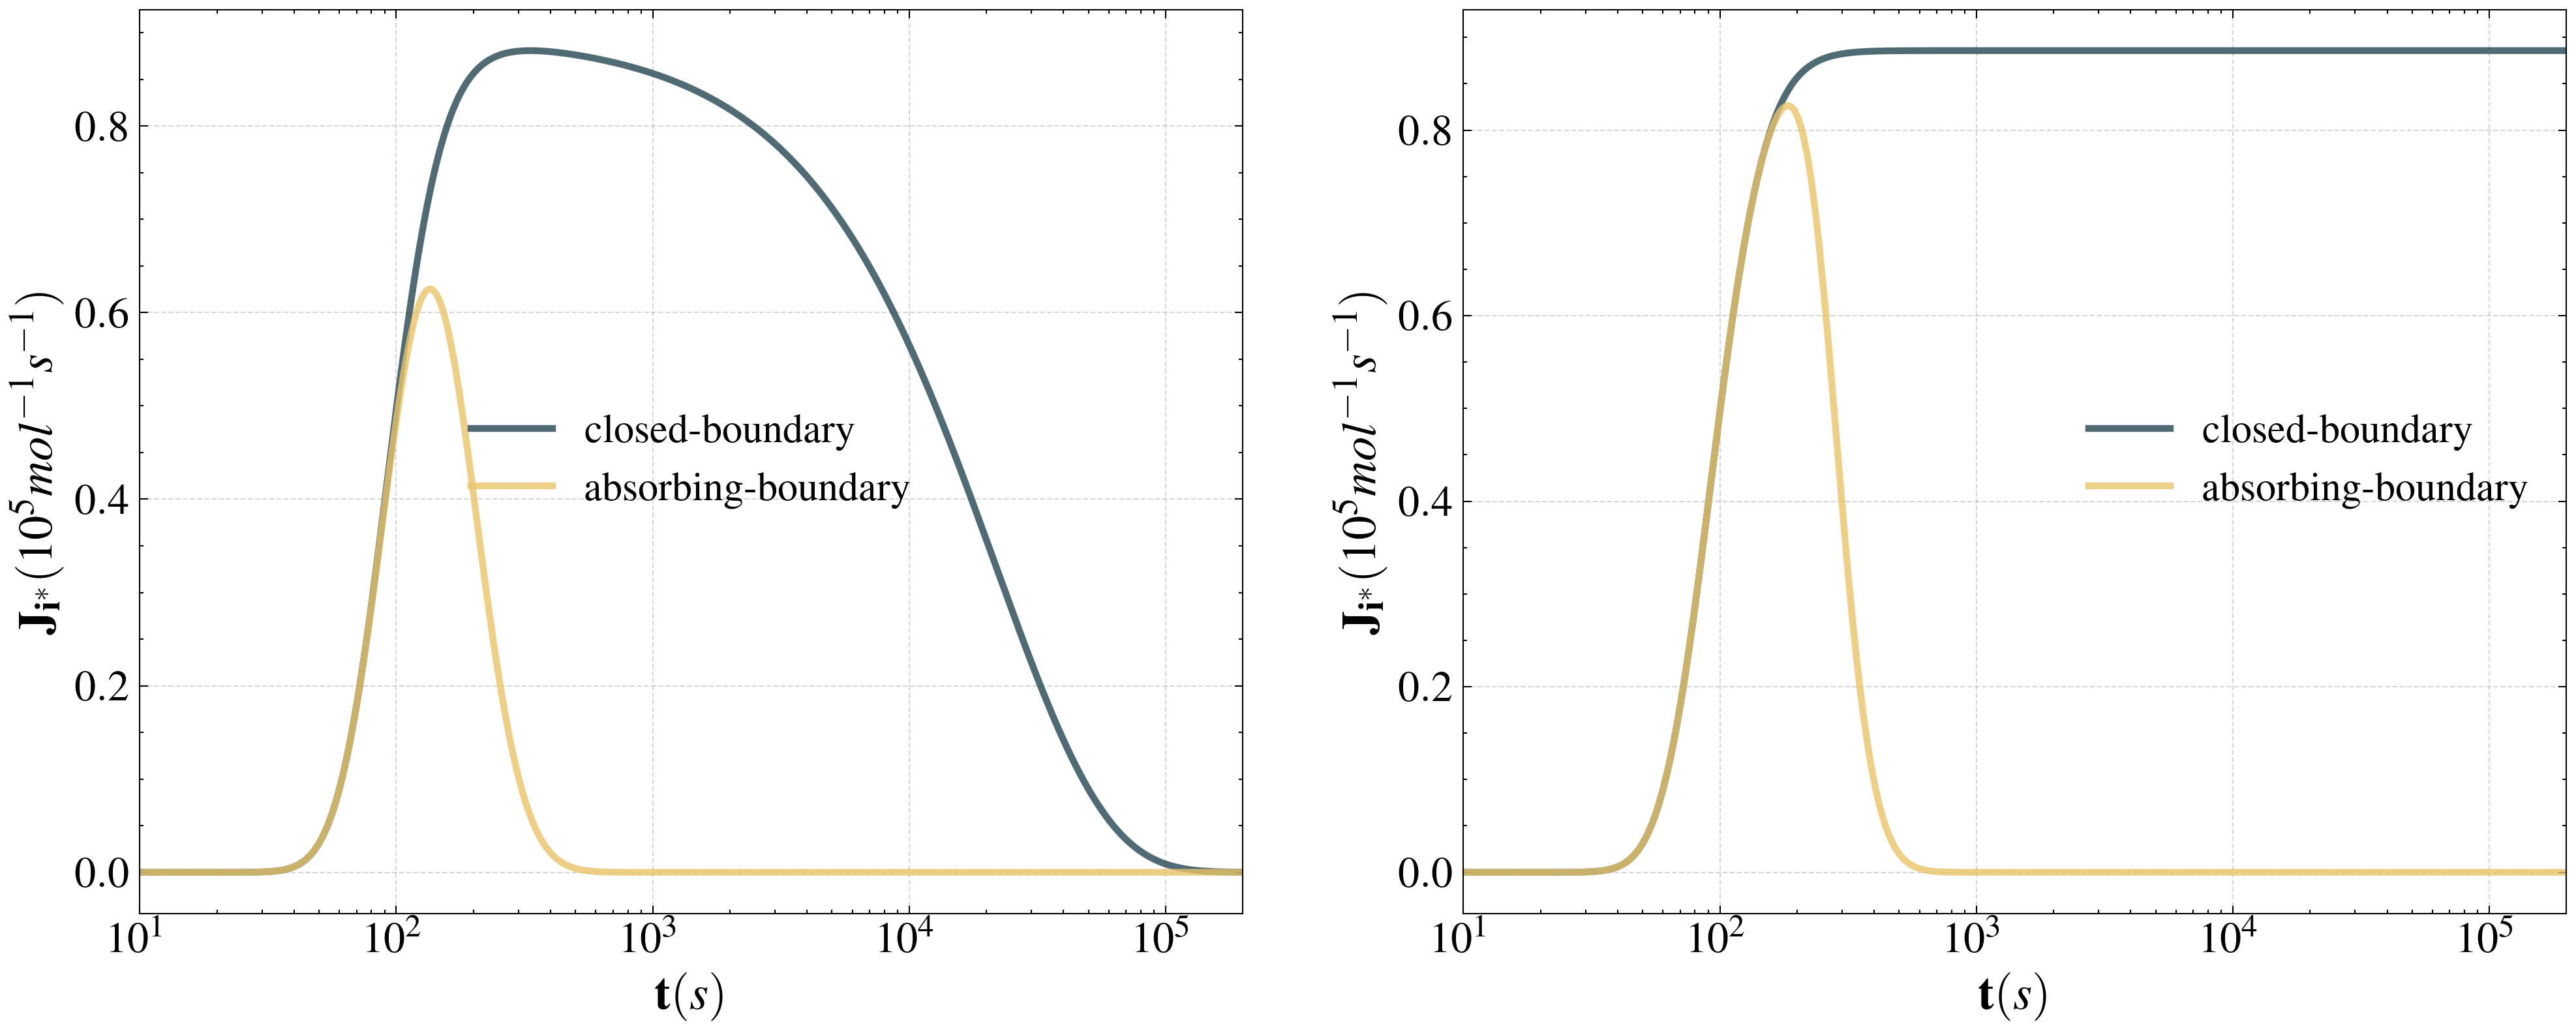

In [132]:
# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=300)
for n in range(len(simulations_closed)):
    # Definir el rango de números de moléculas
    ax = axs[n]
    ax.plot(simulations_closed[n].time/dt, 1e-5*simulations_closed[n].dydt_array[23:, :].sum(axis=0),
                label="closed-boundary", color=colors['closed-boundary'], linestyle = line_styles['closed-boundary'], linewidth=2.5, alpha=0.8)

    ax.plot(simulations_open[n].time/dt, 1e-5*simulations_open[n].dydt_array[23:, :].sum(axis=0),
                label="absorbing-boundary",  color=colors['absorbing-boundary'], linestyle = line_styles['absorbing-boundary'], linewidth=2.5, alpha=0.8)

    ax.set_xlim(1, simulations_open[n].time[-1]/dt)
    ax.set_xlim(1e1, 2e5)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(r"$\mathbf{t} (s)$", fontsize=18)
    ax.set_ylabel(r"$\mathbf{J_{i^{*}}} (10^{5} mol^{-1} s^{-1})$", fontsize=18)
    ax.set_xscale('log')
    ax.legend(fontsize=15, loc='best')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()


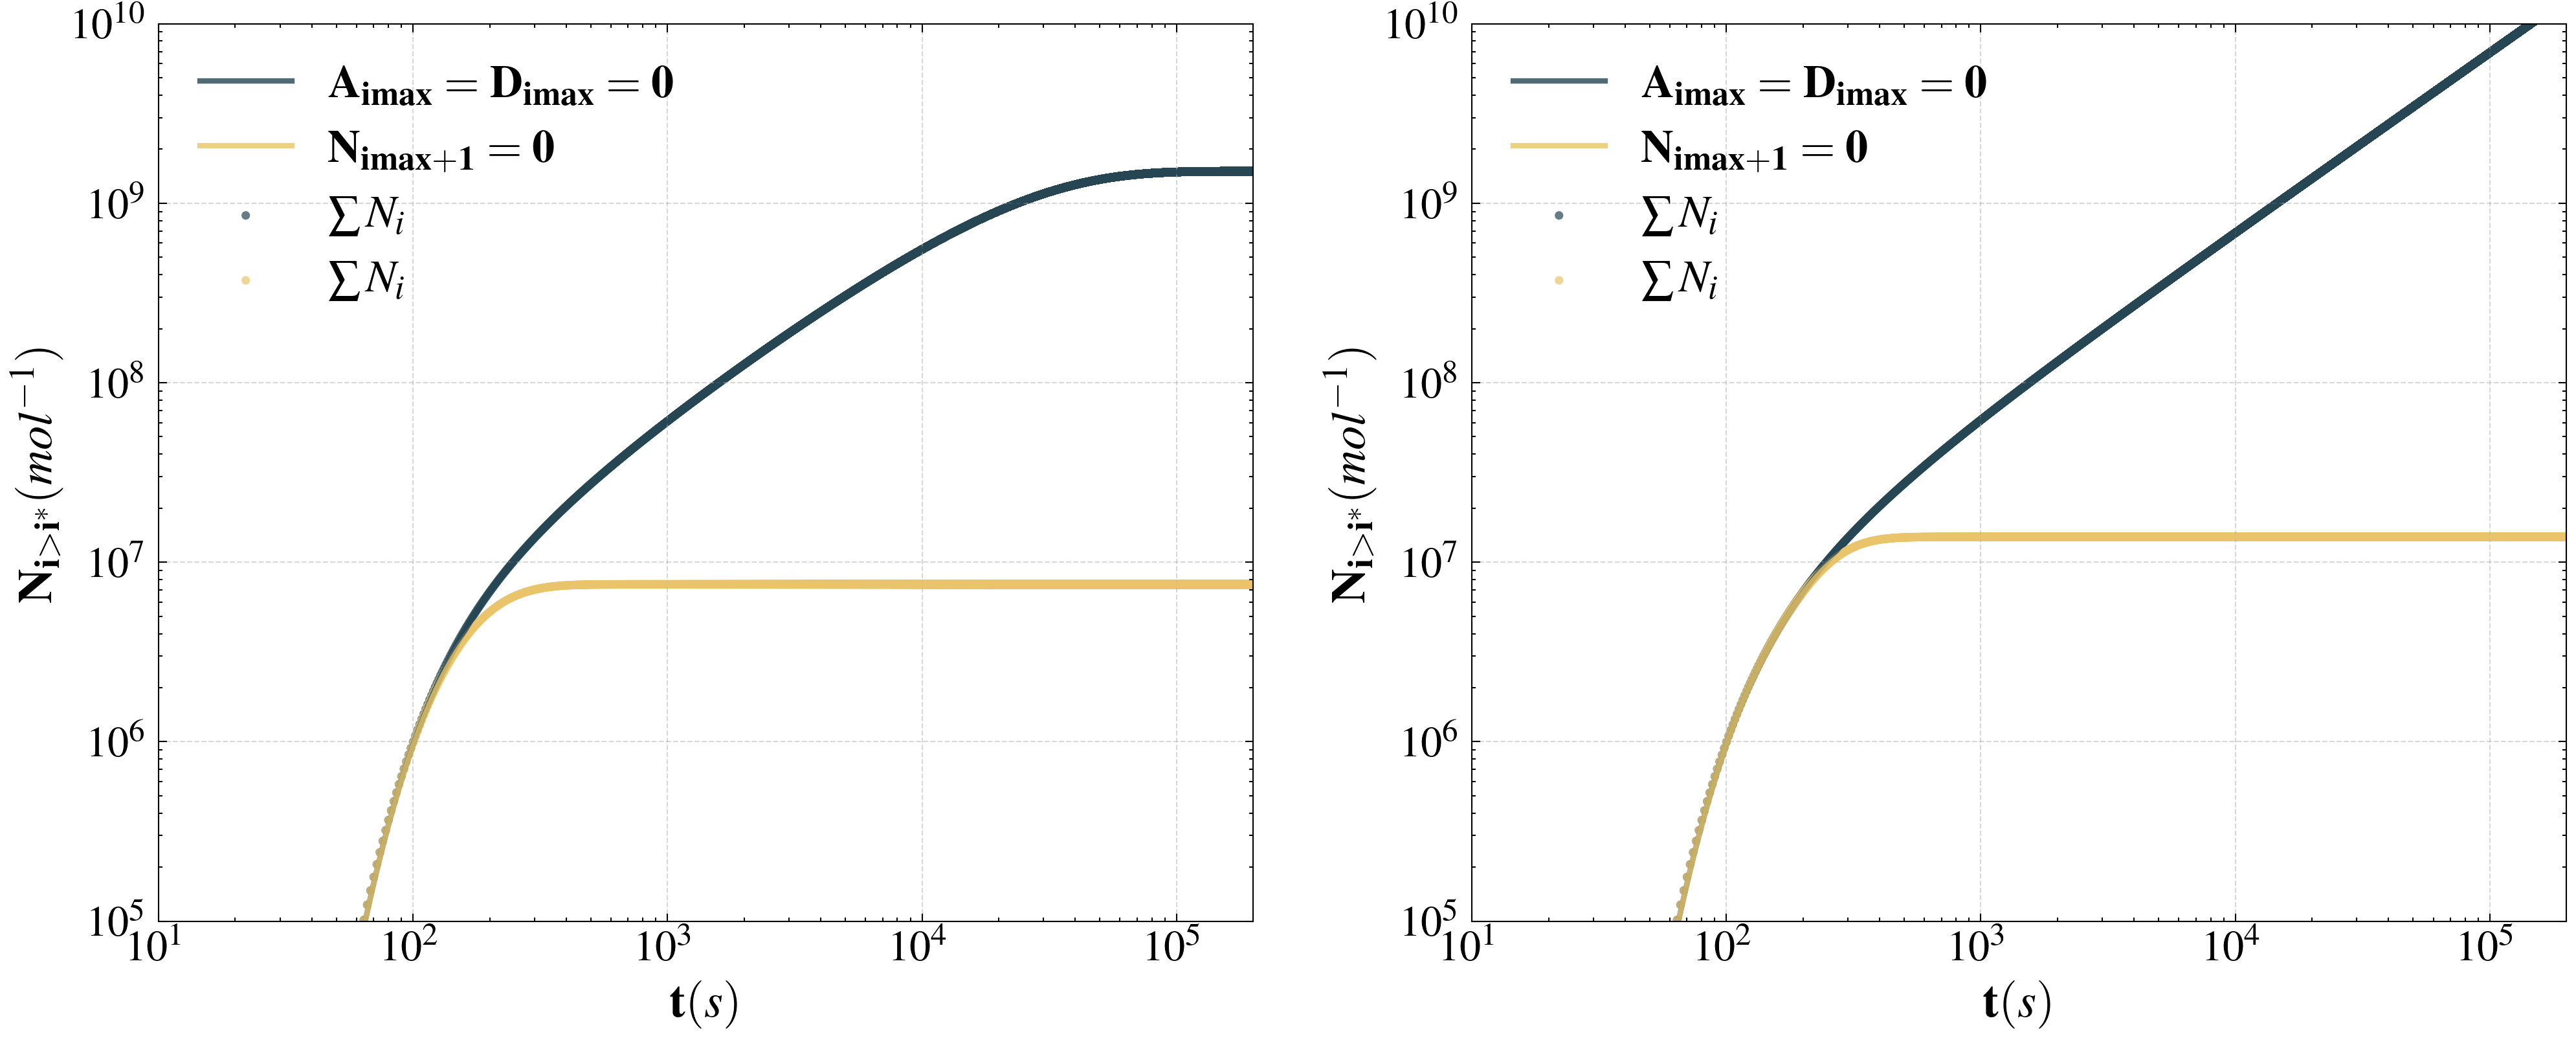

In [130]:
import matplotlib.pyplot as plt
import numpy as np


# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=300)
for n in range(len(simulations_closed)):
    # Definir el rango de números de moléculas
    ax = axs[n]
    ax.plot(sim.time/dt, simulations_closed[n].cluster_array[23:, :].sum(axis=0), color=colors['closed-boundary'], linestyle = line_styles['closed-boundary'], label=r"$\mathbf{A_{imax} = D_{imax} = 0}$", alpha=0.8, linewidth=2)
    ax.plot(sim2.time/dt, simulations_open[n].cluster_array[23:, :].sum(axis=0), color=colors['absorbing-boundary'], linestyle = line_styles['absorbing-boundary'], label=r"$\mathbf{N_{imax+1} = 0}$", alpha=0.8, linewidth=2)

    ax.scatter(sim.time[:-1]/dt, np.cumsum(simulations_closed[n].dydt_array[23:, :].sum(axis=0)[:-1])*np.diff(sim.time), s=10, alpha=0.7, color=colors['closed-boundary'], label=r"$\sum N_i$", edgecolors='none')
    ax.scatter(sim2.time[:-1]/dt, np.cumsum(simulations_open[n].dydt_array[23:, :].sum(axis=0)[:-1])*np.diff(sim2.time), s=10, alpha=0.7, color=colors['absorbing-boundary'], label=r"$\sum N_i$", edgecolors='none')

    ax.set_xlim(1e1, 2e5)
    ax.set_ylim(1e5, 1e10)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(r"$\mathbf{t} (s)$", fontsize=18)
    ax.set_ylabel(r"$\mathbf{N_{i>i^{*}}} (mol^{-1})$", fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=17, loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()



/tmp/ipykernel_20514/1637266078.py:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


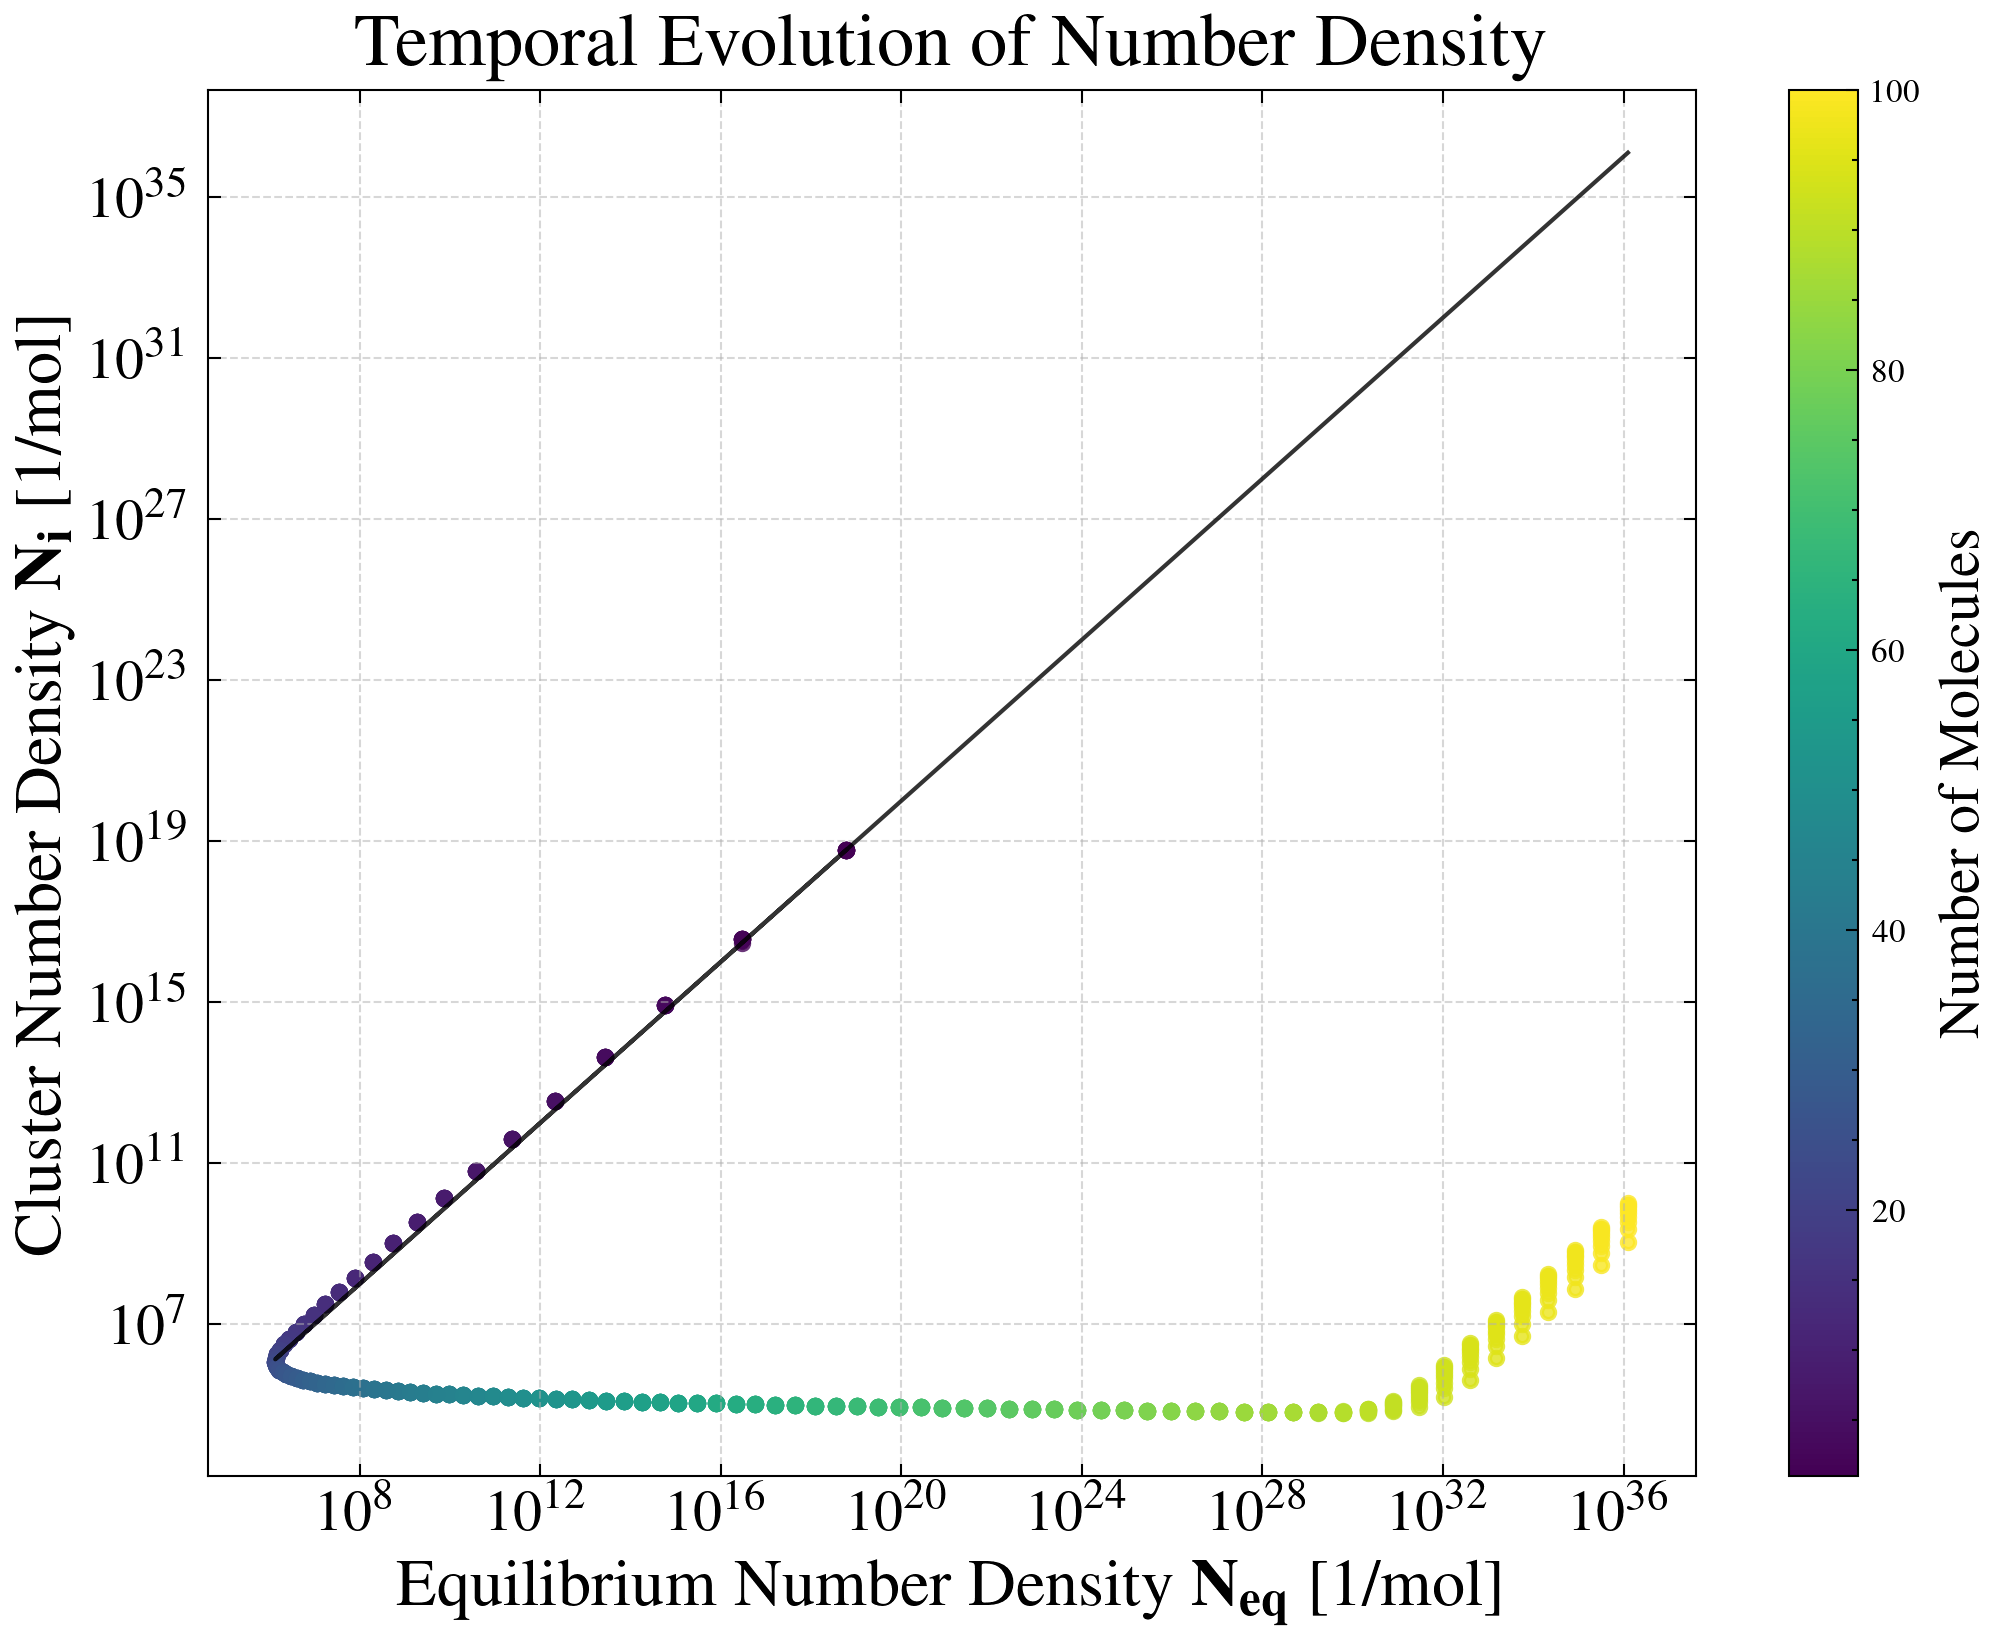

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Definir el rango de números de moléculas
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)
# Genera el colormap basado en el número total de moléculas
colormap = cm.viridis(np.linspace(0, 1, MAX_NUMBER_MOLECULES))

# Define el número de puntos (tiempos) a graficar
num_points = 10
indices = np.linspace(0, len(sim.time) - 1, num_points, dtype=int)

# Itera a través de cada tiempo
for i, index in enumerate(indices):
    # Para cada tiempo, itera sobre cada número de moléculas
    for j, num_mol in enumerate(number_molecules_array):
        # Escoge el color basado en el número de moléculas
        color = colormap[j]
        # Grafica cada punto con su color correspondiente al número de moléculas
        plt.scatter(cluster_physics.number_density_equilibrium(num_mol).magnitude, 
                    sim.cluster_array[j, index], 
                    color=color, s=10, alpha=0.8)
        
plt.plot(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude, cluster_physics.number_density_equilibrium(number_molecules_array).magnitude ,alpha=0.8)

# Ajustes finales de etiquetas y títulos con calidad de publicación
plt.xlabel(r"Equilibrium Number Density $\mathbf{N_{eq}}$ [1/mol]", fontsize=16)
plt.ylabel(r"Cluster Number Density $\mathbf{N_{i}}$ [1/mol]", fontsize=16)
plt.title("Temporal Evolution of Number Density", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Crear y añadir colorbar que corresponde al número de moléculas
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=1, vmax=MAX_NUMBER_MOLECULES))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Number of Molecules', fontsize=14)

plt.show()


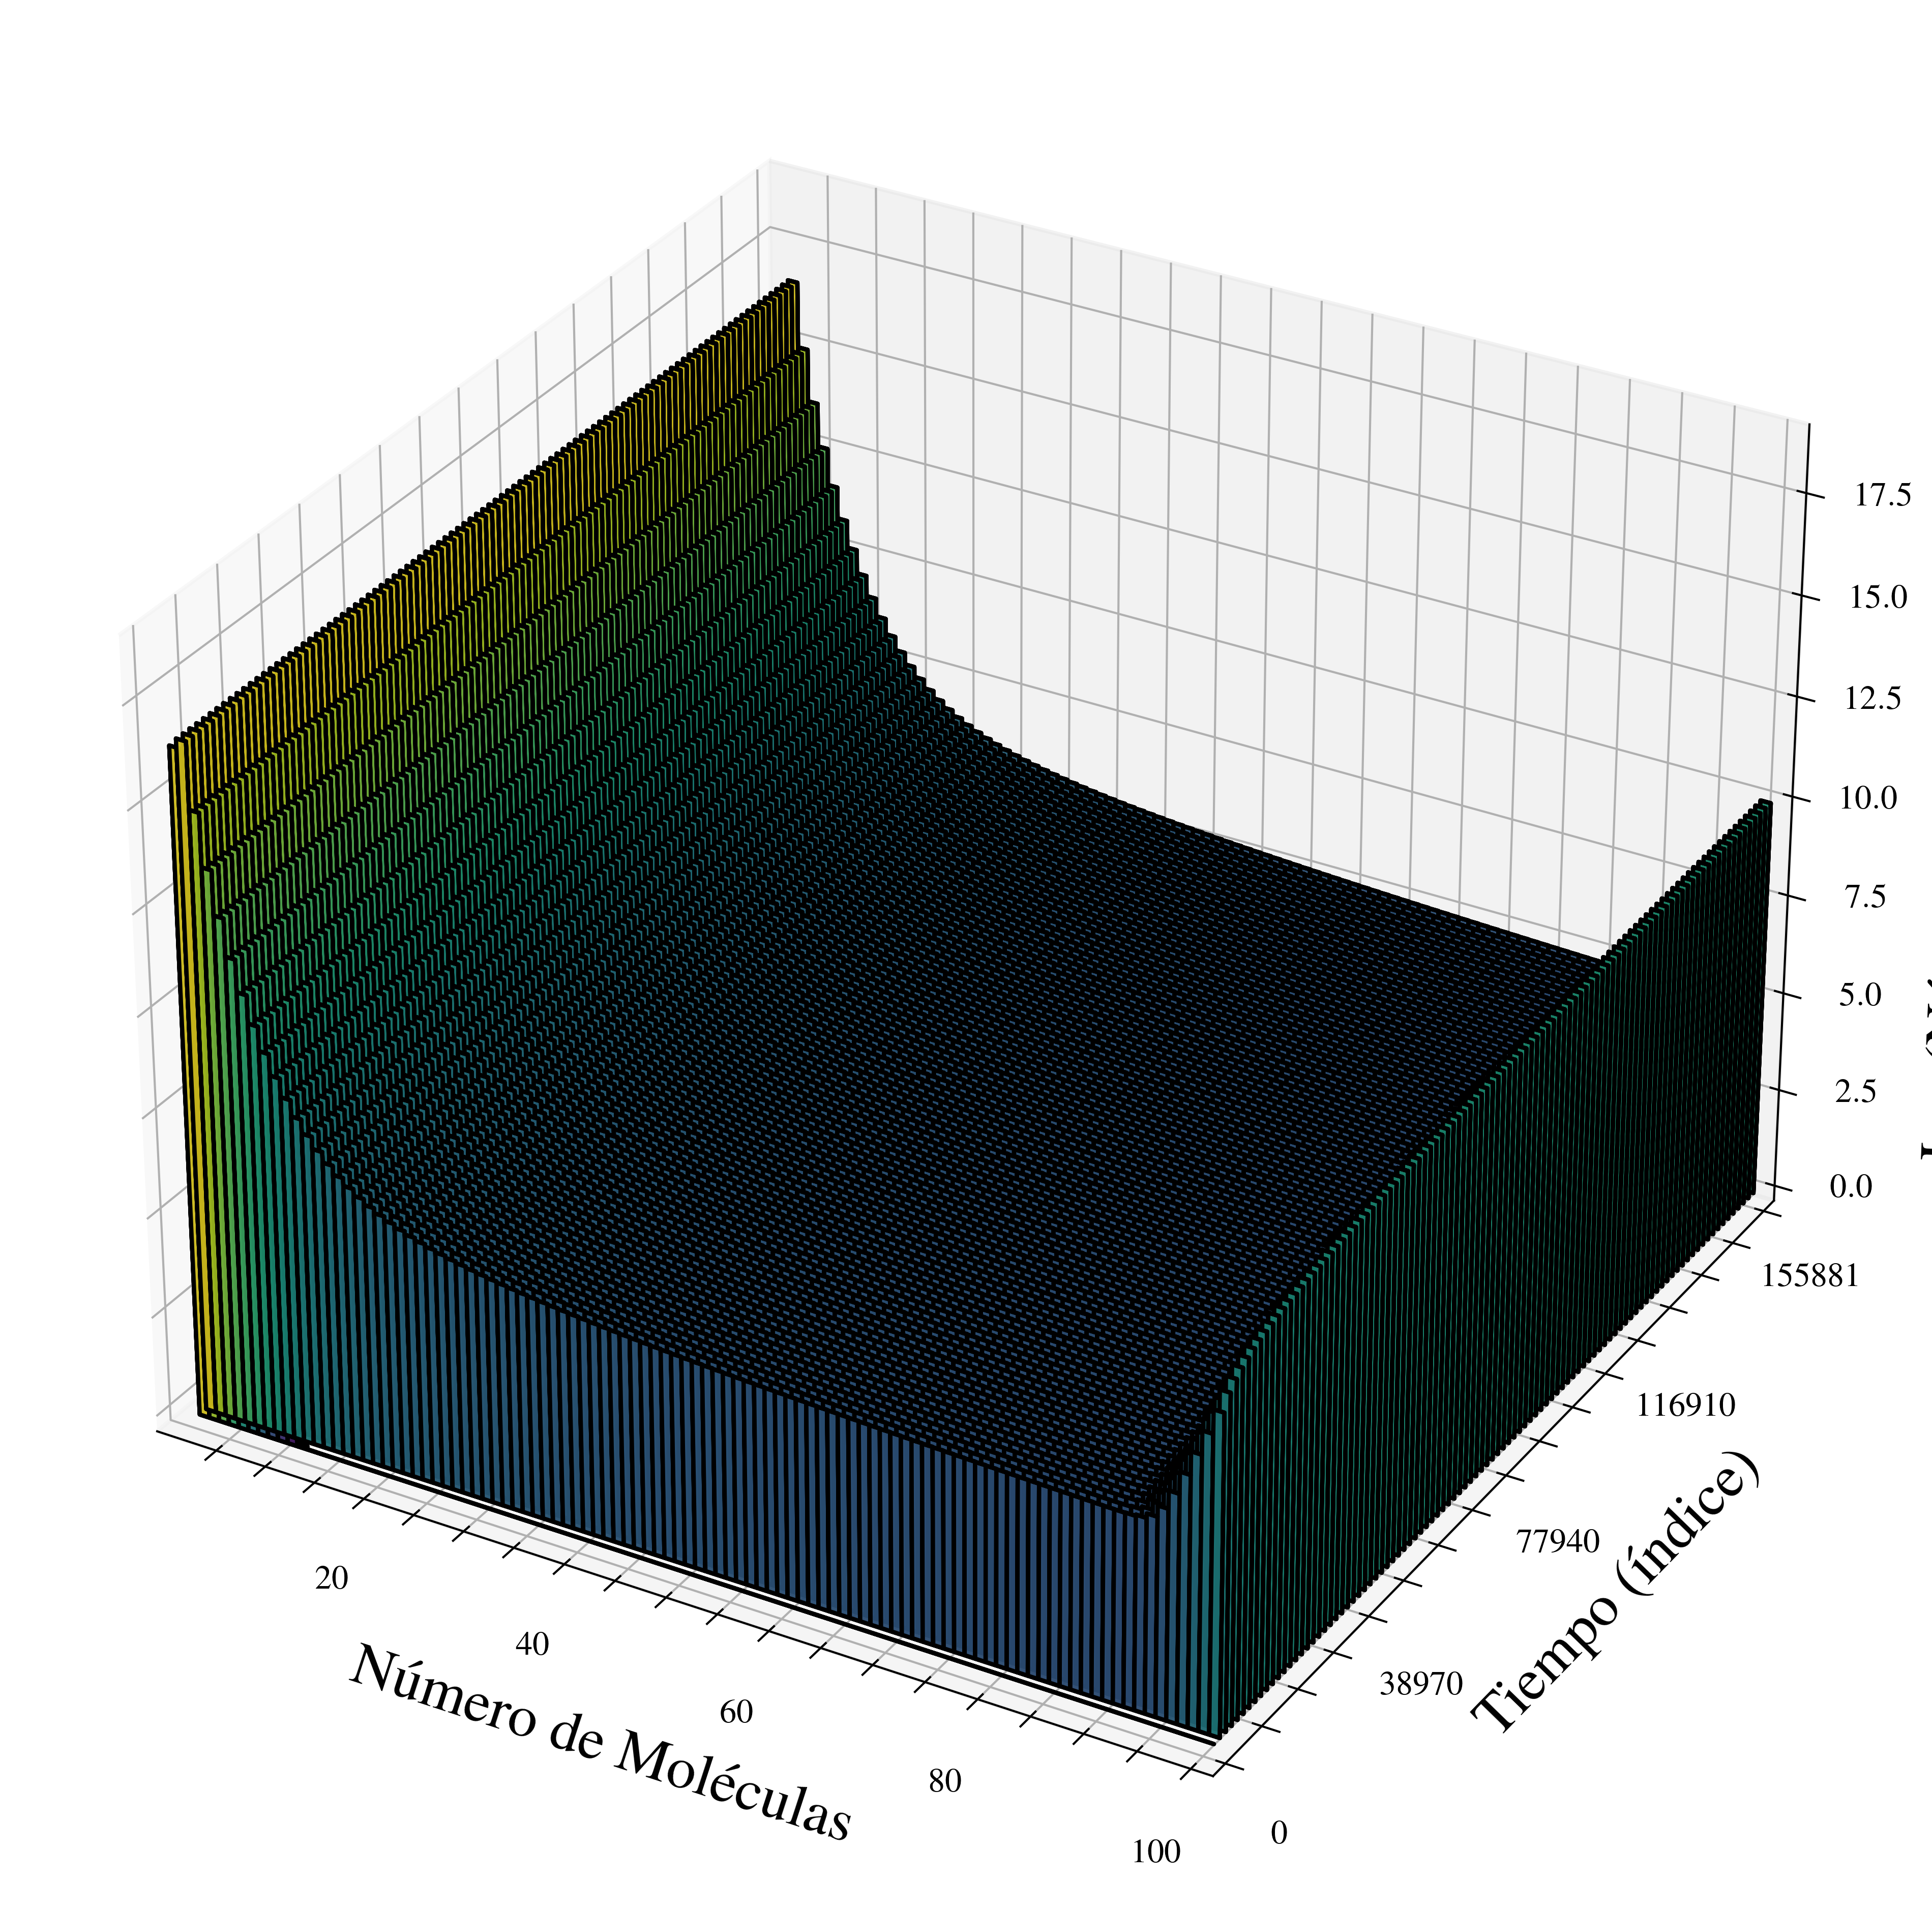

In [80]:
# Configuración inicial del gráfico
fig = plt.figure(figsize=(12, 8))  # Ajusta el tamaño según tus necesidades
ax = fig.add_subplot(111, projection='3d')

# Configuración de la paleta de colores
num_points = 100

# Configuración de los datos
indices = np.linspace(1, len(sim.time) - 1, num_points, dtype=int)
width = (sim.number_molecules_array.max() - sim.number_molecules_array.min()) / num_points  # Ajusta el ancho de las barras
depth = 3.0  # Profundidad de cada barra, ajustable

# Cálculo de los valores de densidad y su normalización para el colormap
all_dz = np.log10(sim.cluster_array[1:] + 1).flatten()  # Calcula todos los valores de densidad
min_dz, max_dz = all_dz.min(), all_dz.max()  # Encuentra los valores mínimos y máximos
norm = plt.Normalize(min_dz, max_dz)  # Crea un objeto para normalizar los valores de densidad

# Añadimos las barras 3D al gráfico
for i, index in enumerate(indices):
    ys = sim.cluster_array[1:, index]
    xs = sim.number_molecules_array[1:]
    zs = sim.time[index]  # Posición en el eje Z para la representación
    dz = np.log10(ys + 1)  # Altura de las barras
    colors = cm.viridis(norm(dz))  # Aplica la normalización a los valores de densidad para obtener los colores
    ax.bar3d(xs, zs, np.zeros_like(xs), width, depth, dz, edgecolor='black', color=colors, alpha=0.8)

# Mejoras en etiquetas y límites
ax.set_xlabel('Número de Moléculas', fontsize=14)
ax.set_ylabel('Tiempo (índice)', fontsize=14)
ax.set_zlabel('Log(Número de Clústeres + 1)', fontsize=14)
ax.set_xlim(sim.number_molecules_array.min(), sim.number_molecules_array.max())
ax.set_ylim(sim.time[0], sim.time[-1])
ax.set_zlim(0, np.log10(sim.cluster_array.max() + 1))
yticks = np.linspace(sim.time[0], sim.time[-1], 5, dtype=int)
ax.set_yticks(yticks)


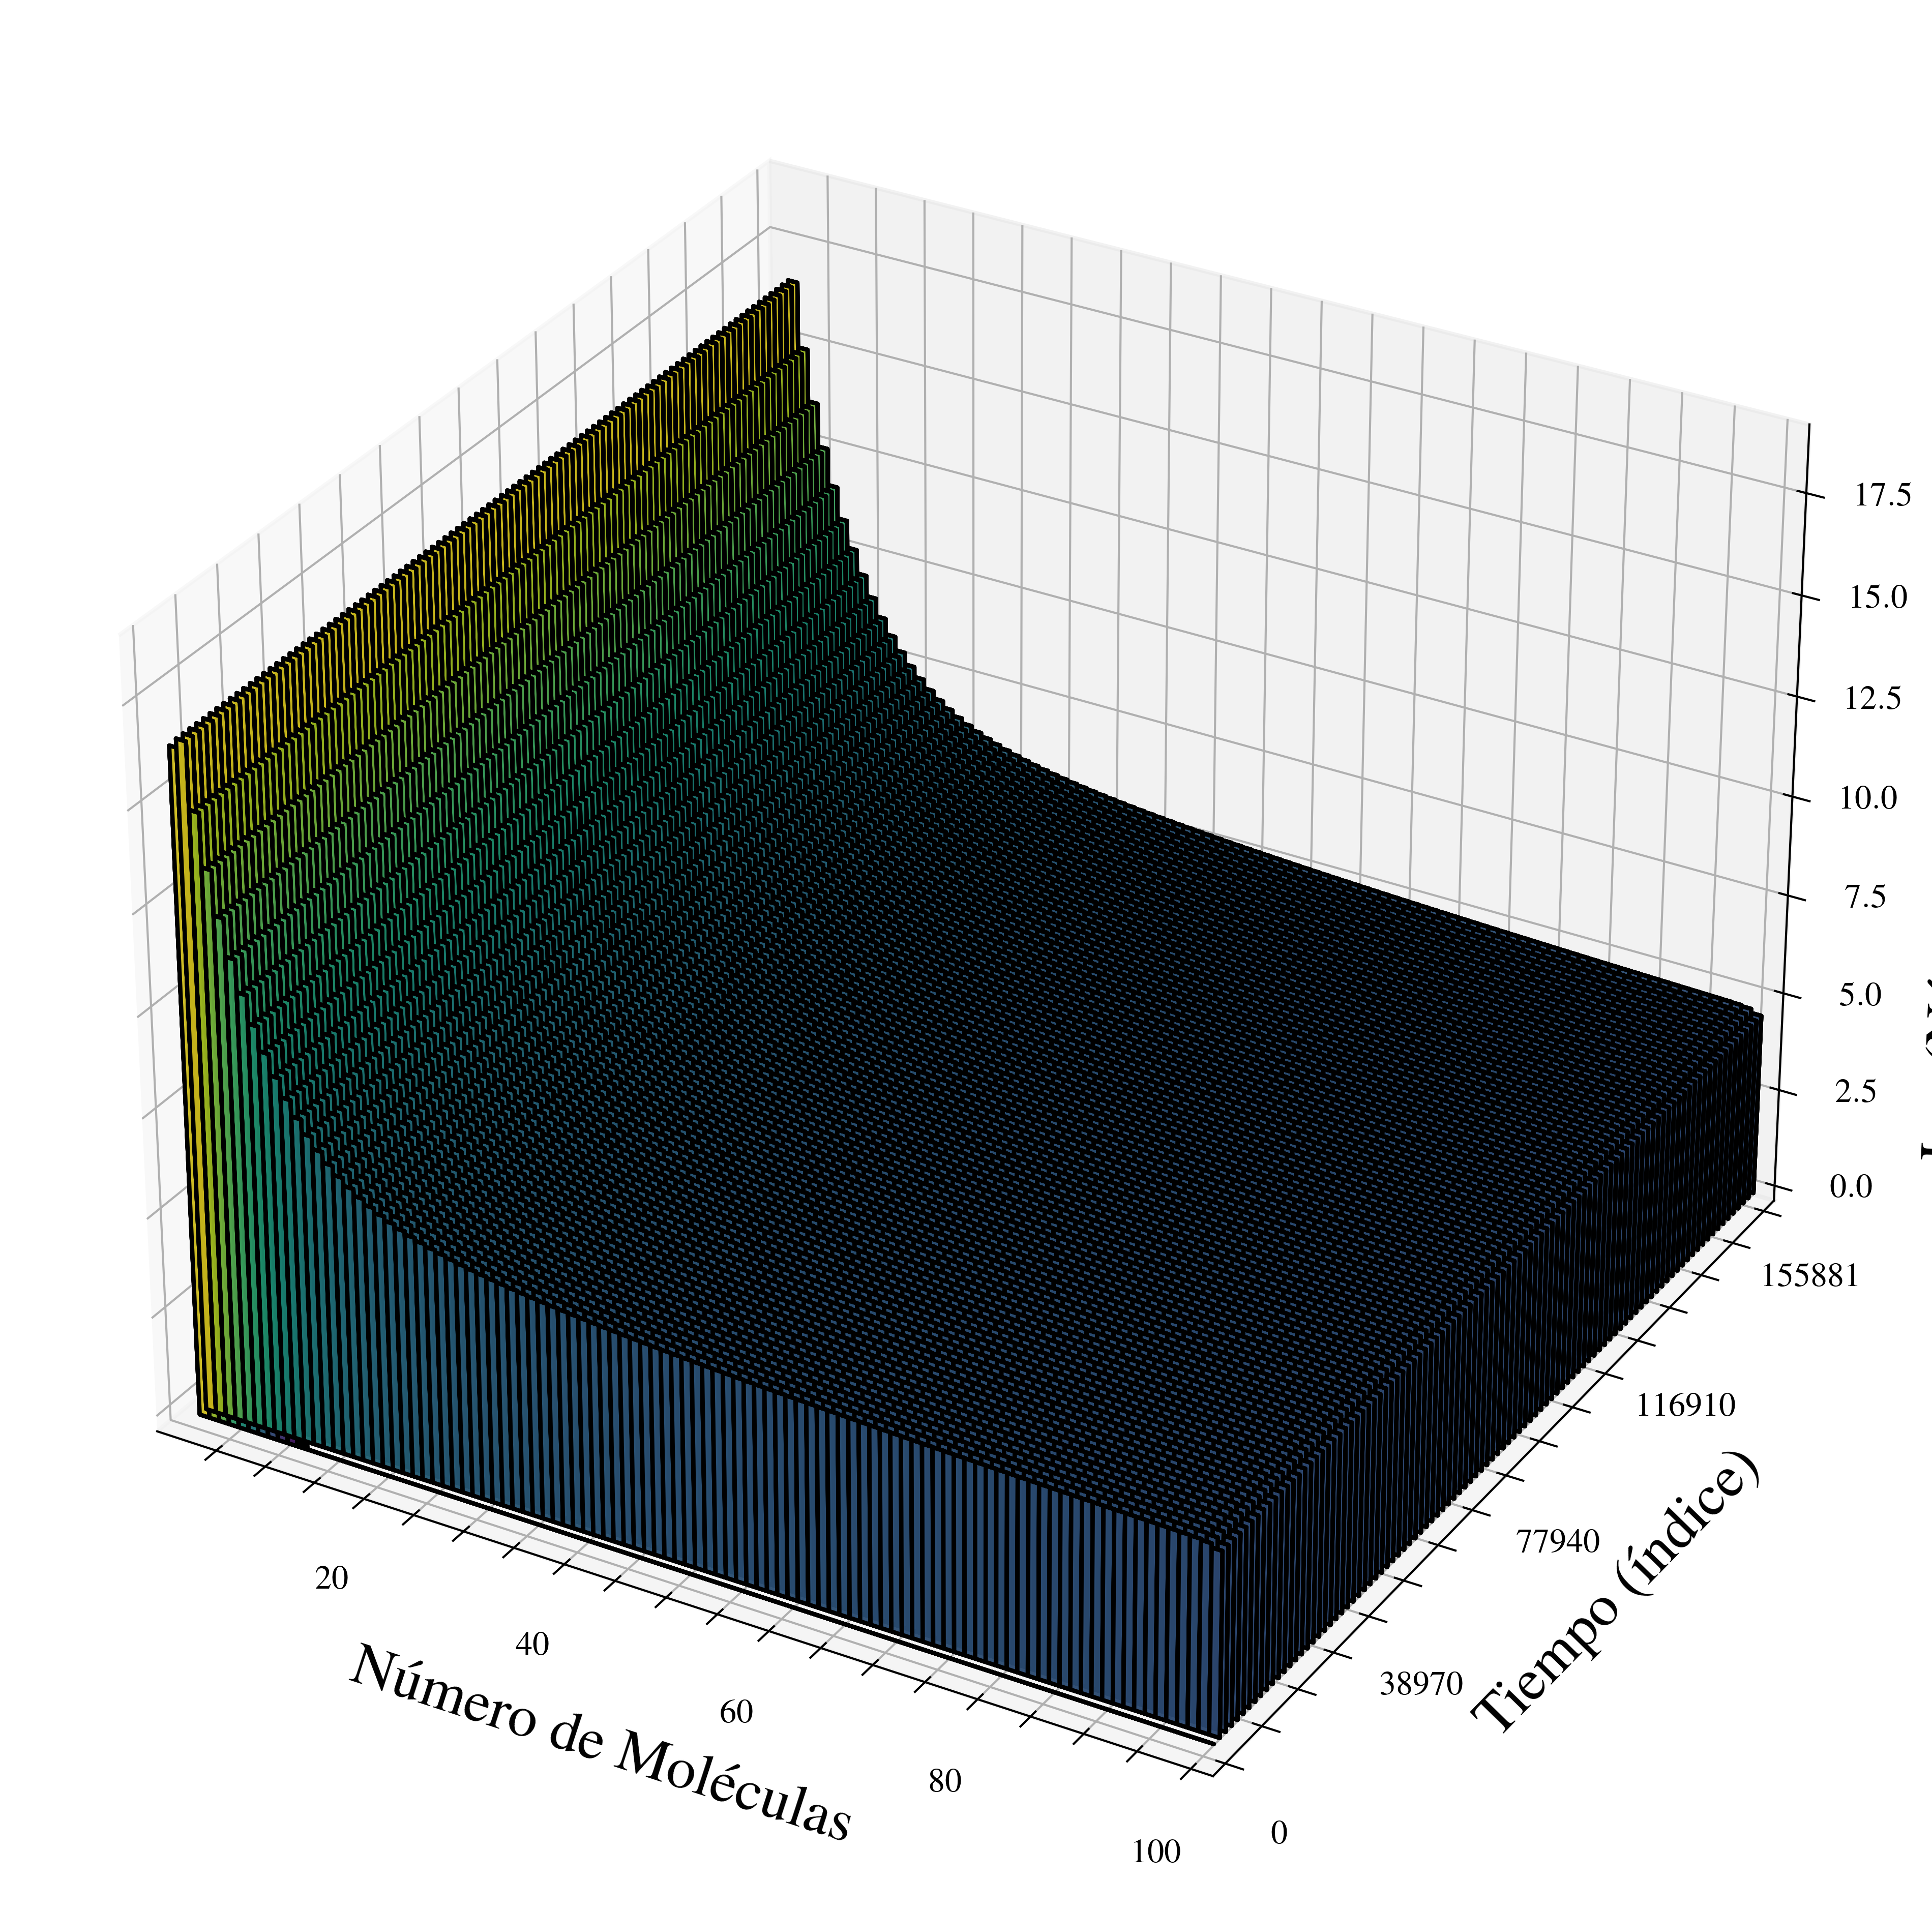

In [81]:
# Configuración inicial del gráfico
fig = plt.figure(figsize=(12, 8))  # Ajusta el tamaño según tus necesidades
ax = fig.add_subplot(111, projection='3d')

# Configuración de la paleta de colores
num_points = 100

# Configuración de los datos
indices = np.linspace(1, len(sim2.time) - 1, num_points, dtype=int)
width = (sim2.number_molecules_array.max() - sim2.number_molecules_array.min()) / num_points  # Ajusta el ancho de las barras
depth = 3.0  # Profundidad de cada barra, ajustable

# Cálculo de los valores de densidad y su normalización para el colormap
all_dz = np.log10(sim2.cluster_array[1:] + 1).flatten()  # Calcula todos los valores de densidad
min_dz, max_dz = all_dz.min(), all_dz.max()  # Encuentra los valores mínimos y máximos
norm = plt.Normalize(min_dz, max_dz)  # Crea un objeto para normalizar los valores de densidad

# Añadimos las barras 3D al gráfico
for i, index in enumerate(indices):
    ys = sim2.cluster_array[1:, index]
    xs = sim2.number_molecules_array[1:]
    zs = sim2.time[index]  # Posición en el eje Z para la representación
    dz = np.log10(ys + 1)  # Altura de las barras
    colors = cm.viridis(norm(dz))  # Aplica la normalización a los valores de densidad para obtener los colores
    ax.bar3d(xs, zs, np.zeros_like(xs), width, depth, dz, edgecolor='black', color=colors, alpha=0.8)

# Mejoras en etiquetas y límites
ax.set_xlabel('Número de Moléculas', fontsize=14)
ax.set_ylabel('Tiempo (índice)', fontsize=14)
ax.set_zlabel('Log(Número de Clústeres + 1)', fontsize=14)
ax.set_xlim(sim2.number_molecules_array.min(), sim2.number_molecules_array.max())
ax.set_ylim(sim2.time[0], sim2.time[-1])
ax.set_zlim(0, np.log10(sim2.cluster_array.max() + 1))
yticks = np.linspace(sim2.time[0], sim2.time[-1], 5, dtype=int)
ax.set_yticks(yticks)


In [7]:
#With Numba 

""" 
# Ejemplo de uso de la clase
params = {
    'temperature': 750,
    'activation_energy': 59920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 150.05,
    'mass_density': 2.5,
    'melting_point': 1300,
    'heat_fusion': 52 * 1e3,
    'supersaturation_ratio': 20.5,
    'sigma': 0.15, 
    'method': 'melting'
}

Computation time: 1.4030 seconds
Computation time: 0.0169 seconds
Computation time: 0.1812 seconds
Computation time: 0.8422 seconds
 """

 # Without Numba
""" 
Computation time: 0.0014 seconds
Computation time: 0.0812 seconds
Computation time: 0.8159 seconds
Computation time: 4.1370 seconds 
"""

' \nComputation time: 0.0014 seconds\nComputation time: 0.0812 seconds\nComputation time: 0.8159 seconds\nComputation time: 4.1370 seconds \n'